In [15]:
from collections import Counter
from tqdm import tqdm 
from colorama import Style,Fore
import os
from dotenv import load_dotenv
import json
import time
load_dotenv()

True

In [16]:
def openJson(path):
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def saveJson(path,data):
    with open(path, "w", encoding="utf-8") as f:
       json.dump(data, f, ensure_ascii=False, indent=2)
       print(Style.BRIGHT+Fore.GREEN+'\n json saved'+Style.RESET_ALL)

In [19]:
channelsF2 = openJson("../jsons/channelsF2.json")
len(channelsF2)

1836

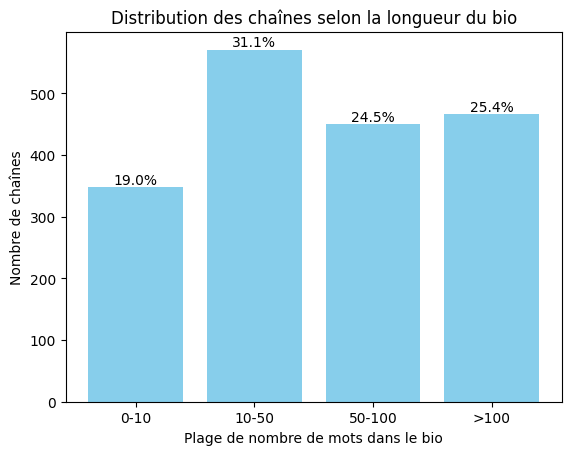

In [20]:
import matplotlib.pyplot as plt

plages = {
    '0-10': 0,
    '10-50': 0,
    '50-100': 0,
    '>100': 0
}

for item in channelsF2:
    bio = item.get('bio', '').strip()
    nb_mots = len(bio.split())
    
    if nb_mots <= 10:
        plages['0-10'] += 1
    elif nb_mots <= 50:
        plages['10-50'] += 1
    elif nb_mots <= 100:
        plages['50-100'] += 1
    else:
        plages['>100'] += 1

labels = list(plages.keys())
counts = list(plages.values())
total = sum(counts)
percentages = [count / total * 100 for count in counts]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color='skyblue')

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{pct:.1f}%', 
            ha='center', va='bottom', fontsize=10)

plt.xlabel('Plage de nombre de mots dans le bio')
plt.ylabel('Nombre de chaînes')
plt.title('Distribution des chaînes selon la longueur du bio')
plt.show()


In [21]:
from scrapetube import get_channel
from googleapiclient.discovery import build

def getContext(channel_id):
    api_key = os.getenv("YOUTUBE_API_KEY2")
    youtube = build('youtube', 'v3', developerKey=api_key)

    video_ids = []
    for video in get_channel(channel_id, limit=3, sort_by='newest', content_type='videos'):
        video_ids.append(video['videoId'])

    if not video_ids:
        return "No videos found."

    request = youtube.videos().list(part='snippet', id=','.join(video_ids))
    response = request.execute()

    combined = ""
    for item in response['items']:
        title = item['snippet'].get('title', 'No title')
        description = item['snippet'].get('description', 'No description')
        tags = ', '.join(item['snippet'].get('tags', [])) if 'tags' in item['snippet'] else 'No tags'

        combined += f"Title: {title}\nDescription: {description}\nTags: {tags}\n\n"

    return combined


In [ ]:
temp = 0
for item in tqdm(channelsF2):
    bio = item.get('bio', '').strip()
    nb_mots = len(bio.split())
    
    if nb_mots <= 100 :
        context = getContext(item['id_chaine'])
        item['context'] = context
        
    temp+=1
    if temp >= 100:
        saveJson("../jsons/channelsF2.json",channelsF2)
        temp = 0
   
saveJson("../jsons/channelsF2.json",channelsF2)

# 1.Echantillon

In [ ]:
import random

random.seed(42)
echantillon = random.sample(channelsF2, 200)

for item in echantillon:
    item['link']=f"https://www.youtube.com/channel/{item['id_chaine']}"
    item['pertinente']=""
    
saveJson("../jsons/echantillon.json",echantillon)
print(len(echantillon))

# 2.Manuel Validation 

In [7]:
echantillon = openJson("../jsons/echantillon.json")
len(echantillon)

200

In [8]:
valeurs = [item.get("pertinente") for item in echantillon]
compteur = Counter(valeurs)

for valeur, nb in compteur.items():
    print(f"{valeur} → {nb} chaines")

non → 170 chaines
oui → 30 chaines


# 3.With LLM

In [9]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

In [10]:
gemini_flash_1 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_1"))
gemini_flash_2 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_2"))
gemini_flash_3 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_3"))

In [15]:
sysprompt = """
# La définition d’autosuffisance

L'autosuffisance est la démarche visant à acquérir la capacité de subvenir par soi-même à ses besoins fondamentaux, 
en premier lieu alimentaires par l'autoconsommation – c'est-à-dire produire, récolter et conserver un maximum de sa propre nourriture, 
souvent en privilégiant le bio, le local et le saisonnier. 

L'autosuffisance Plus qu'une simple recherche d'autonomie matérielle, elle représente un engagement pour être moins dépendant du système économique et social extérieur, impliquant des choix concrets comme trouver un lieu propice et le concevoir judicieusement (par exemple en permaculture), 
ainsi qu'un changement dans la manière de valoriser son temps et de consommer, formant ainsi le fondement d'une vie plus autonome.

---

# Votre mission

- Décider si une chaine concerne la thématique de l'autosuffisance en se basant sur ses métadonnées (Nom chaine, Bio).
  
- Les chaînes des autosuffisants ou qui partagent de contenu sur l’autosuffisance sont pertinentes.

- Attribuer un score entier de 1 à 10 pour évaluer la pertinence de la chaine par rapport à la thématique de l'autosuffisance.

---

# Votre réponse  

- La réponse doit être au format JSON :  
  
    "decision": "oui ou non",
    "justification": "Justifiez votre décision avec des arguments"
    "score": votre èvaluation
 
"""

userprompt = """
Nom de la chaine
---
{nom_chaine}

Bio
---
{bio}
"""

prompt = ChatPromptTemplate([
    ("system", sysprompt),
    ("user", userprompt)
])

chain_1 = prompt | gemini_flash_1
chain_2 = prompt | gemini_flash_2
chain_3 = prompt | gemini_flash_3


## Test

In [16]:
input = {
    "nom_chaine": "L’Ôton’home",
      "bio": "Nous sommes un couple parent de 2 jeunes garçons et avons acheté à l’été 2020 une GRANDE GRANGE sur un peu plus de 3 hectares de terrain dans le Tarn. Notre objectif: transformer cette grange en HABITATION la plus AUTONOME possible, ce par nos propres moyens, et en faire notre petit paradis. Venez partager notre aventure et suivre ce projet un peu fou ici.\n\nLe but de notre chaîne: montrer toutes les étapes de la TRANSFORMATION de la GRANGE en HABITATION, échanger sur l’AUTONOMIE, partager nos DIY en matière de PRODUITS MÉNAGERS et COSMÉTIQUES, toujours dans une optique d’AUTONOMIE.\n\nPrécision importante: nous ne sommes PAS des professionnels du bâtiment donc nos vidéos n'ont pas valeur de tutoriels mais de simples partages d'expérience.\n\nN’hésitez pas à laisser vos commentaires et à vous abonner à la chaîne. Vous pouvez également nous retrouver sur Facebook et Tipeee. En espérant pouvoir vous inspirer.\n\nDes bises,\n\nAurélie & David",
       }
print(input)
print(chain_1.invoke(input))

{'nom_chaine': 'L’Ôton’home', 'bio': "Nous sommes un couple parent de 2 jeunes garçons et avons acheté à l’été 2020 une GRANDE GRANGE sur un peu plus de 3 hectares de terrain dans le Tarn. Notre objectif: transformer cette grange en HABITATION la plus AUTONOME possible, ce par nos propres moyens, et en faire notre petit paradis. Venez partager notre aventure et suivre ce projet un peu fou ici.\n\nLe but de notre chaîne: montrer toutes les étapes de la TRANSFORMATION de la GRANGE en HABITATION, échanger sur l’AUTONOMIE, partager nos DIY en matière de PRODUITS MÉNAGERS et COSMÉTIQUES, toujours dans une optique d’AUTONOMIE.\n\nPrécision importante: nous ne sommes PAS des professionnels du bâtiment donc nos vidéos n'ont pas valeur de tutoriels mais de simples partages d'expérience.\n\nN’hésitez pas à laisser vos commentaires et à vous abonner à la chaîne. Vous pouvez également nous retrouver sur Facebook et Tipeee. En espérant pouvoir vous inspirer.\n\nDes bises,\n\nAurélie & David"}
```js